In [14]:
import numpy as np
from scipy import fftpack

In [15]:
class encoder:




    def __init__(self ,video ,  mb_size = 16 , alpha=1):
        self.iframe = video[0]
        self.pframes = video[1:]
        self.mb_size = mb_size
        self.alpha = alpha

        QUANTIZATION_MATRIX =np.array([
            [16 ,  11 ,   10 ,   16 ,   24 ,   40 ,   51 ,  61],
            [12  , 12  ,  14  ,  19  ,  26  ,  58  ,  60  , 55],
            [14  , 13  ,  16  ,  24  ,  40  ,  57  ,  69  , 56],
            [14  , 17  ,  22  ,  29  ,  51  ,  87  ,  80  , 62],
            [18  , 22  ,  37  ,  56  ,  68  , 109  , 103  , 77],
            [24  , 35  ,  55  ,  64  ,  81  , 104  , 113  , 92],
            [49  , 64  ,  78  ,  87  , 103  , 121  , 120  ,101],
            [72  , 92  ,  95  ,  98  , 112  , 100  , 103  , 99]
                ])

        tmp = np.zeros((8,8,3))
        tmp[:,:,0] , tmp[:,:,1] ,tmp[:,:,2] = QUANTIZATION_MATRIX,QUANTIZATION_MATRIX,QUANTIZATION_MATRIX
        self.QUANTIZATION_MATRIX = tmp

    def blocking(self, im , blockSize):
        blocks = []
        for i in range(blockSize , im.shape[0]+1 ,blockSize):
            for j in range(blockSize ,im.shape[1]+1 , blockSize):
                B = im[i-blockSize:i , j-blockSize:j]
                blocks.append(B)

        blocks = np.array(blocks)
        return blocks


    def rgb2ycbcr(self , im):
        xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
        ycbcr = im.dot(xform.T)
        ycbcr[:,:,[1,2]] += 128
        return np.uint8(ycbcr)


    def dct(self , a):
        return fftpack.dct( fftpack.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )



    def iframe_coding(self):
        mbs = self.blocking(self.iframe , 8)
        coded = np.zeros(mbs.shape)
        for i in range(mbs.shape[0]):
            coded[i] = self.dct(self.rgb2ycbcr(mbs[i]))  /  (self.QUANTIZATION_MATRIX * self.alpha)
        return coded.astype(int)
        
        






In [16]:
class decoder:
    def __init__(self , alpha = 1 , targetSize=(256, 256)):
        self.alpha = alpha
        self.targetSize = targetSize
        QUANTIZATION_MATRIX =np.array([
            [16 ,  11 ,   10 ,   16 ,   24 ,   40 ,   51 ,  61],
            [12  , 12  ,  14  ,  19  ,  26  ,  58  ,  60  , 55],
            [14  , 13  ,  16  ,  24  ,  40  ,  57  ,  69  , 56],
            [14  , 17  ,  22  ,  29  ,  51  ,  87  ,  80  , 62],
            [18  , 22  ,  37  ,  56  ,  68  , 109  , 103  , 77],
            [24  , 35  ,  55  ,  64  ,  81  , 104  , 113  , 92],
            [49  , 64  ,  78  ,  87  , 103  , 121  , 120  ,101],
            [72  , 92  ,  95  ,  98  , 112  , 100  , 103  , 99]
                ])

        tmp = np.zeros((8,8,3))
        tmp[:,:,0] , tmp[:,:,1] ,tmp[:,:,2] = QUANTIZATION_MATRIX,QUANTIZATION_MATRIX,QUANTIZATION_MATRIX
        self.QUANTIZATION_MATRIX = tmp

    def func1(self):
        print('hi')

    def ycbcr2rgb(self,im):
        xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
        rgb = im.astype(np.float)
        rgb[:,:,[1,2]] -= 128
        rgb = rgb.dot(xform.T)
        np.putmask(rgb, rgb > 255, 255)
        np.putmask(rgb, rgb < 0, 0)
        return np.uint8(rgb)

    def idct(self , a):
        return fftpack.idct( fftpack.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')


    def reconstructFromBlocks(self , blocks , targetShape = (265,256) , blockSize = 16):
        numOfBlockInCol = int(targetShape[0] / blockSize)
        numOfBlockInRow = int(targetShape[1] / blockSize)

        recoIMG = np.array([])
        
        count = -1 

        for i in range( numOfBlockInCol):
            recoRow = np.array([])
            for j in range(numOfBlockInRow):
                count += 1
                if recoRow.size == 0:
                    recoRow = blocks[i * numOfBlockInRow]
                else:
                    recoRow = np.hstack((recoRow,blocks[count]))
            
            if recoIMG.size == 0:
                recoIMG = recoRow
            else:
                recoIMG = np.vstack((recoIMG,recoRow))

        return recoIMG


    def iframe_decoding(self , coded):
        decoded = np.zeros(coded.shape)
        for i in range(coded.shape[0]):
            tmp = coded[i] * (self.QUANTIZATION_MATRIX * self.alpha)
            # print(tmp.shape)
            decoded[i] = self.ycbcr2rgb(self.idct(tmp))
        # print(decoded.shape, "&&&&&&&&&&&&&&&&")
        return  self.reconstructFromBlocks( decoded , targetShape = self.targetSize , blockSize = 8).astype("uint8")


In [17]:
import skvideo as vi
import skvideo.io
import skvideo.motion
import skvideo.measure
import skvideo.datasets
import matplotlib.pyplot as plt


raw_suzie = vi.io.vread("suzie_qcif.y4m",as_grey=False)

print(raw_suzie.shape)

(150, 144, 176, 3)


In [18]:
enc = encoder(raw_suzie  , 16)
codedd = enc.iframe_coding()

# a = enc.rgb2ycbcr(raw_suzie[0])

In [19]:
decoder1 = decoder(targetSize=(144,176))

decodedIframe = decoder1.iframe_decoding(codedd)


C:\Users\Farhad\AppData\Local\Temp\ipykernel_13196\2602225899.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


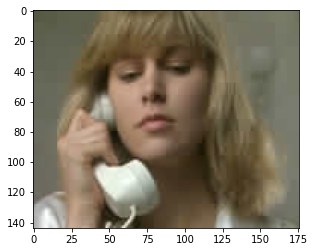

In [20]:
plt.imshow(decodedIframe, cmap="gray")